# Storing Pulse Templates: `PulseStorage` and Serialization

So far, we have constructed new pulse templates in code for each session (which were discarded afterwards). We now want to store them persistently in the file system to be able to reuse them in later sessions. For this, qupulse offers us serialization and deserialization using the `PulseStorage` and `StorageBackend` classes.

The pulse storage manages the (de-)serialization to JSON and requires a storage backend to persistently store the serialized data. This can for example be a `FilesystemBackend` or a `DictBackend`. Let us first use a `DictBackend` to inspect the serialized pulse.

__Attention:__ Due to the fact that PulseStorage enforces unique identifiers, executing the cells in this notebook out of order or rerunning them will likely result in errors. You will have to restart the Kernel in that case.

## Single Pulses
First we will have a look at how to store pulses that do not contain other pulse templates. To store a pulse, __the pulse needs to have an identifier__. If you forgot to give the pulse an identifier one can use the `rename` method which returns a new pulse with the requested identifier.

### Storing

In [1]:
import pprint
from qupulse.pulses import TablePT
from qupulse.serialization import PulseStorage, DictBackend

dict_backend = DictBackend()
dict_pulse_storage = PulseStorage(dict_backend)

table_pulse = TablePT({'default': [('t_begin', 'v_begin', 'hold'),
                                   ('t_end', 'v_end', 'linear')]}, identifier='my_pulse')

dict_pulse_storage['my_pulse'] = table_pulse

pprint.pprint(dict_backend.storage)

{'my_pulse': '{\n'
             '    "#identifier": "my_pulse",\n'
             '    "#type": '
             '"qupulse.pulses.table_pulse_template.TablePulseTemplate",\n'
             '    "entries": {\n'
             '        "default": [\n'
             '            [\n'
             '                "t_begin",\n'
             '                "v_begin",\n'
             '                "hold"\n'
             '            ],\n'
             '            [\n'
             '                "t_end",\n'
             '                "v_end",\n'
             '                "linear"\n'
             '            ]\n'
             '        ]\n'
             '    },\n'
             '    "measurements": [],\n'
             '    "parameter_constraints": []\n'
             '}'}


Now to store this in a file system we need to replace the `DictBackend` with a `FilesystemBackend`. The following code will create the file `'./serialized_pulses/my_pulse.json'`.

In [2]:
from qupulse.serialization import FilesystemBackend

filesystem_backend = FilesystemBackend('./serialized_pulses')
file_pulse_storage = PulseStorage(filesystem_backend)

if 'my_pulse' in file_pulse_storage:
    del file_pulse_storage['my_pulse']

file_pulse_storage['my_pulse'] = table_pulse

### Loading
Now we will load a pulse that is shipped only as a JSON file. It is a single sine with frequency `omega`. Note that loading the same pulse multiple times will give you the same object.

Loading the same pulse multiple times gives you the same object


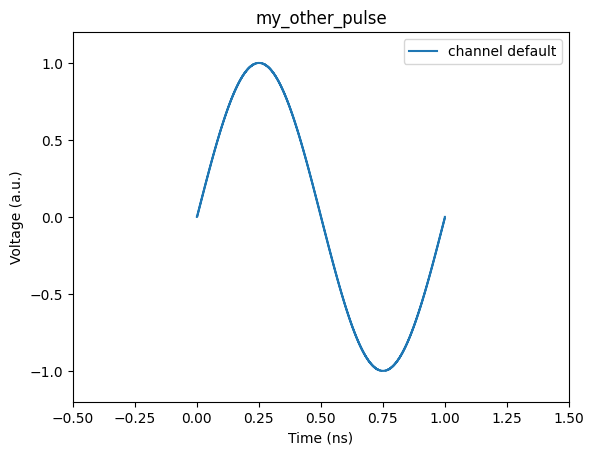

In [3]:
import math
from qupulse.plotting import plot

sine = file_pulse_storage['my_other_pulse']

_ = plot(sine, {'omega': 2*math.pi}, sample_rate=1000, show=False)

if sine is file_pulse_storage['my_other_pulse']:
    print('Loading the same pulse multiple times gives you the same object')

## Composed pulses and the role of identifiers
If we have a pulse that contains other pulses all pulses that have an identifier are stored seperatly. Each `PulseStorage` instance expects that identifiers are unique (see below). Anonymous subpulses are stored together with their parent.

We will now only use a dictionary as a backend it is easier to see what happens.

### Storing

In [4]:
from qupulse.pulses import RepetitionPT, SequencePT

# anonymous pulse template
repeated_sine = RepetitionPT(sine, 'N_sine')

my_sequence = SequencePT(repeated_sine, table_pulse, identifier='combined')

dict_pulse_storage['combined'] = my_sequence

pprint.pprint(dict_backend.storage)

{'combined': '{\n'
             '    "#identifier": "combined",\n'
             '    "#type": '
             '"qupulse.pulses.sequence_pulse_template.SequencePulseTemplate",\n'
             '    "subtemplates": [\n'
             '        {\n'
             '            "#type": '
             '"qupulse.pulses.repetition_pulse_template.RepetitionPulseTemplate",\n'
             '            "body": {\n'
             '                "#identifier": "my_other_pulse",\n'
             '                "#type": "reference"\n'
             '            },\n'
             '            "repetition_count": "N_sine"\n'
             '        },\n'
             '        {\n'
             '            "#identifier": "my_pulse",\n'
             '            "#type": "reference"\n'
             '        }\n'
             '    ]\n'
             '}',
 'my_other_pulse': '{\n'
                   '    "#identifier": "my_other_pulse",\n'
                   '    "#type": '
                   '"qupulse.pulses.f

As you see, the serialization of 'combined' explicitly contains the anonymous `RepetitionPulseTemplate` but references to 'my_pulse' and 'my_other_pulse' which are stored as separate entries.

## Pulse registry and unique identifiers
There is the possibility to store pulse templates on construction into a pulse registry. This can be a `PulseStorage`. To set a pulse storage as the default pulse registry call `set_to_default_registry`

In [5]:
from qupulse.pulses import FunctionPT

dict_pulse_storage.set_to_default_registry()

new_pulse = FunctionPT(0, 1, identifier='new_pulse')

pprint.pprint(dict_backend.storage)

{'combined': '{\n'
             '    "#identifier": "combined",\n'
             '    "#type": '
             '"qupulse.pulses.sequence_pulse_template.SequencePulseTemplate",\n'
             '    "subtemplates": [\n'
             '        {\n'
             '            "#type": '
             '"qupulse.pulses.repetition_pulse_template.RepetitionPulseTemplate",\n'
             '            "body": {\n'
             '                "#identifier": "my_other_pulse",\n'
             '                "#type": "reference"\n'
             '            },\n'
             '            "repetition_count": "N_sine"\n'
             '        },\n'
             '        {\n'
             '            "#identifier": "my_pulse",\n'
             '            "#type": "reference"\n'
             '        }\n'
             '    ]\n'
             '}',
 'my_other_pulse': '{\n'
                   '    "#identifier": "my_other_pulse",\n'
                   '    "#type": '
                   '"qupulse.pulses.f

As you see each newly created pulse is put into the pulse storage. Creating a new pulse with the same name will fail:

In [6]:
try:
    new_pulse = FunctionPT(0, 1, identifier='new_pulse')
except RuntimeError as err:
    print('Oh No!!!')
    print(err)
    print()

Oh No!!!
('Pulse with name already exists', 'new_pulse')



We have to either explicitly overwrite the registry or delete the old pulse from it:

In [7]:
try:
    new_pulse = FunctionPT(0, 1, identifier='new_pulse', registry=dict())
except:
    raise
else:
    print('Overwriting the registry works!')

del dict_pulse_storage['new_pulse']
try:
    new_pulse = FunctionPT(0, 1, identifier='new_pulse')
except:
    raise
else:
    print('Deleting the pulse works, too!')

Overwriting the registry works!
Deleting the pulse works, too!
